In [23]:
import cv2 as cv
from matplotlib import pyplot as plt
import json
import numpy as np
import os
import colorsys

# ref
# https://iieej.org/trans/IEVC/IEVC2012/PDF/4B-1.pdf
# https://arxiv.org/pdf/1804.01753.pdf

In [24]:
validare_folder = "../../validare/validare/"

In [25]:
def print_image(image, gray=True, title=None, output_dir=None):
    fig, axes = plt.subplots(1, 1, figsize=(12, 6))
    if not gray:
        image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        axes.imshow(image_rgb)
        image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    else:
        axes.imshow(image, cmap="gray")
        image_gray = image
    axes.set_title("Image")
    axes.axis("off")

    if title:
        plt.suptitle(title)
    plt.tight_layout()

    if output_dir:
        plt.savefig(output_dir)
    else:
        plt.show()


def print_trio(skin, edges, segment):
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))
    skin = cv.cvtColor(skin, cv.COLOR_BGR2RGB)
    axes[0].imshow(skin, cmap="gray")
    axes[0].set_title("Skin")
    axes[0].axis("off")

    axes[1].imshow(edges)
    axes[1].set_title("Edges")
    axes[1].axis("off")

    segment = cv.cvtColor(segment, cv.COLOR_BGR2RGB)
    axes[2].imshow(segment)
    axes[2].set_title("Segment")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()


def generate_neon_color():
    neon_color = (
        np.random.randint(150, 256),
        np.random.randint(150, 256),
        np.random.randint(150, 256),
    )
    return neon_color


def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip("#")
    rgb = tuple(int(hex_color[i : i + 2], 16) for i in (0, 2, 4))
    return rgb


def rgb_to_hsl(rgb):
    return cv.cvtColor(np.uint8([[rgb]]), cv.COLOR_RGB2HSV)

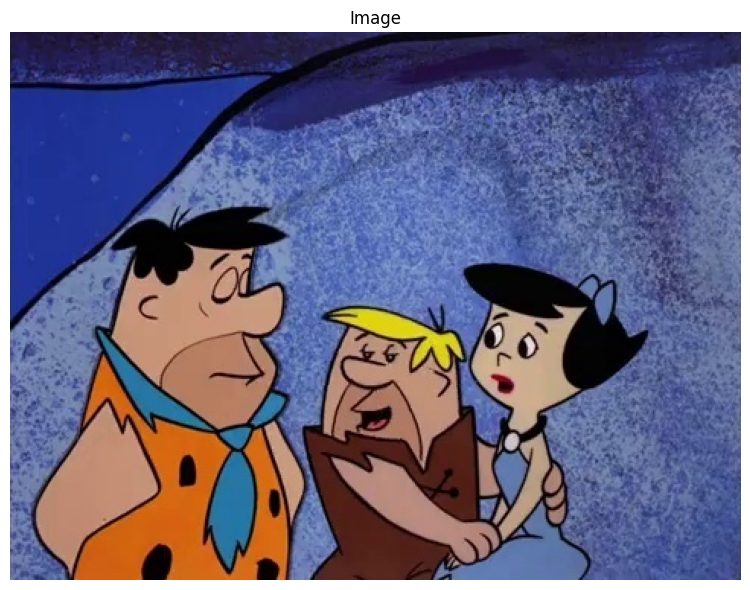

In [26]:
images = os.listdir(validare_folder)
image = images[71]

img = cv.imread(validare_folder + image)
print_image(img, gray=False)

In [27]:
skin_tones = [
    "98806c",
    "826659",
    "edc7a0",
    "caa98a",
    "bc8d72",
    "f4ceaa",
    "c09a87",
    "ac8678",
    "d3aa8a",
    "bd857e",
    "b1908b",
    "e6c9c5",
    "dab4a7",
    "dfb9a9",
    "e1cbbe",
    "fedac6",
    "e7d7c0",
    "e3c9bc",
    "efbdb0",
    "d7b9b9",
]
skin_tones = np.array([rgb_to_hsl(hex_to_rgb(color)) for color in skin_tones])
min_values = skin_tones.min(axis=0)
max_values = skin_tones.max(axis=0)
print(min_values)
print(max_values)

[[[  0  36 130]]]
[[[ 18 100 254]]]


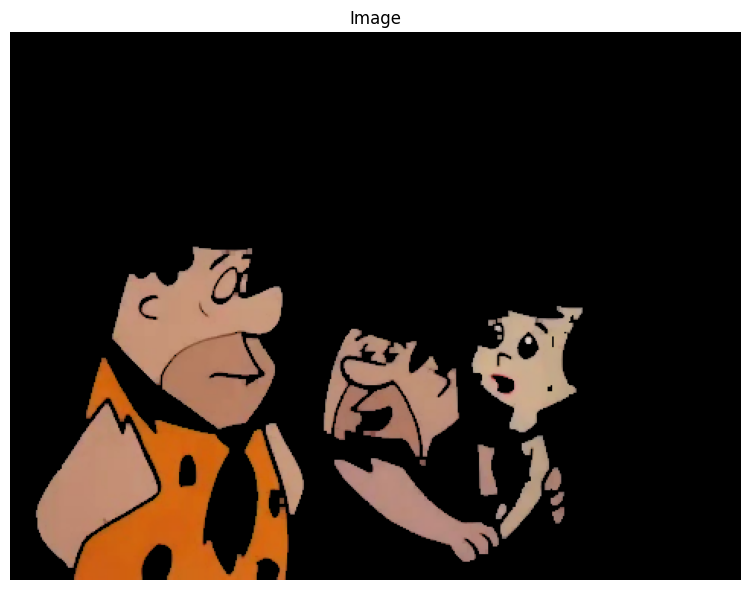

In [28]:
def skin_extraction(img):
    hue_range = [0, 18]
    luminance_range = [110, 255]
    img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

    lower_hue = np.array([hue_range[0], 0, luminance_range[0]])
    upper_hue = np.array([hue_range[1], 255, luminance_range[1]])

    mask = cv.inRange(img_hsv, lower_hue, upper_hue)

    result_image = cv.bitwise_and(img, img, mask=mask)
    result_image = cv.morphologyEx(
        result_image, cv.MORPH_OPEN, np.ones((3, 3), np.uint8)
    )
    return result_image


skin = skin_extraction(img)
print_image(skin, gray=False)

# for image in images[:10]:
#     img = cv.imread(validare_folder + image)
#     skin = skin_extraction(img)
#     print_image(skin, gray=False)

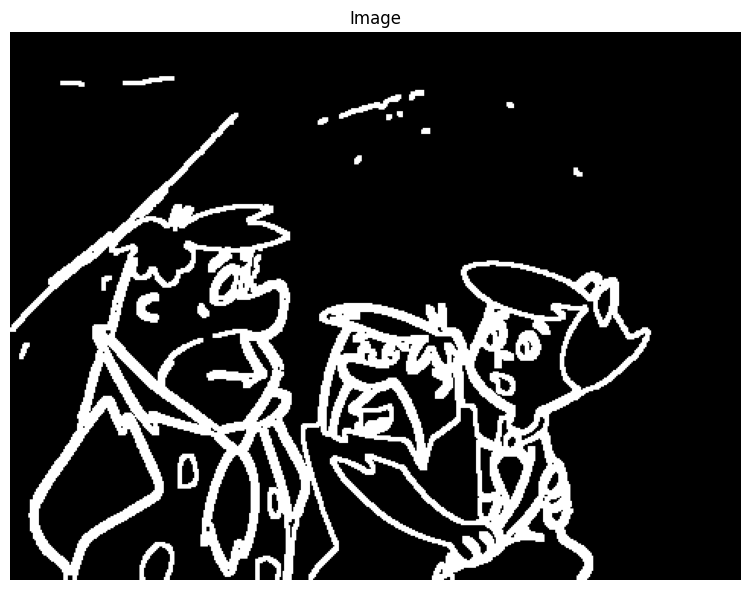

In [29]:
def edge_detect(img):
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img = cv.GaussianBlur(img, (3, 3), 0)
    img = cv.Canny(img, 180, 250)
    # img = cv.morphologyEx(img, cv.MORPH_CLOSE, None, iterations=1)
    # img = cv.morphologyEx(img, cv.MORPH_OPEN, None, iterations=1)
    img = cv.dilate(img, None, iterations=1)
    return img


edges = edge_detect(img)
print_image(edges, gray=True)

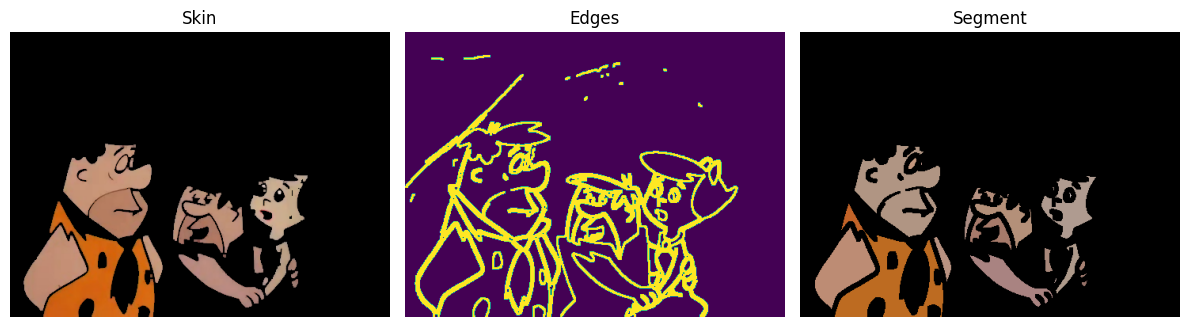

In [30]:
def face_segmentation(
    skin_color_image, edge_image, min_region_size=1, max_image_ratio=0.03
):
    h, w = edge_image.shape[:2]
    edge_copy = cv.bitwise_not(edge_image.copy())
    edge_copy = cv.cvtColor(edge_copy, cv.COLOR_GRAY2BGR)

    mask = np.zeros((h + 2, w + 2), np.uint8)

    total_pixels = h * w

    for y in range(h):
        for x in range(w):
            if not np.all(skin_color_image[y, x] == 0):
                if np.all(edge_image[y, x] == 0):
                    color = skin_color_image[y, x].tolist()

                    number_pixels, _, _, _ = cv.floodFill(
                        edge_copy, mask, (x, y), color
                    )

                    if (
                        number_pixels > 0
                        and number_pixels / total_pixels <= max_image_ratio
                    ):
                        # print(number_pixels, total_pixels, number_pixels / total_pixels)
                        edge_copy[mask[1:-1, 1:-1] == 255] = [0, 0, 0]

    gray = cv.cvtColor(edge_copy, cv.COLOR_BGR2GRAY)
    _, thresholded = cv.threshold(gray, 254, 255, cv.THRESH_BINARY_INV)
    result = cv.bitwise_and(edge_copy, edge_copy, mask=thresholded)
    return result


face_segment = face_segmentation(skin, edges)
print_trio(skin, edges, face_segment)

In [31]:
# def find_face(image):
#     pass


# for i, img in enumerate(images):
#     img = cv.imread(validare_folder + img)
#     skin = skin_extraction(img)
#     edges = edge_detect(img)
#     face_segment = face_segmentation(skin, edges)
#     print_trio(skin, edges, face_segment)